In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.1-{platform}-linux_x86_64.whl torchvision

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch

plt.rcParams['axes.facecolor'] = 'white'

    100% |████████████████████████████████| 67.1MB 63.5MB/s 
fastai 1.0.48 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.


In [0]:
def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])

def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    Compute the Hessian of `output` with respect to `inputs`
    hessian((x * y).sum(), [x, y])
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)

    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad

    return out

### Check if q (.) (Kq)**(alpha -1) is convex wrt non-neg orthant

In [0]:
n, M = 50, 5000
alpha = 5 * np.random.rand()
eps = 1e-8

ones = np.array(n * [[1.]])
ones = torch.tensor(ones)

K = 0.01*np.random.rand(n, n)
K = (K * K.T) + 0 * np.eye(n)
K = torch.tensor(K)

print(np.linalg.matrix_rank(K), np.linalg.det(K), np.min(np.linalg.eigvals(K)), np.max(np.linalg.eigvals(K)))

p = np.random.dirichlet(n*[1], M).T
p = torch.tensor(p, requires_grad=True)
Kpa = (torch.clamp_min(K @ p, eps))**(alpha-1)

q = torch.tensor(np.random.dirichlet(n*[1], M).T)
Kqa = (torch.clamp_min(K @ q, eps))**(alpha-1)

z = 0.5 * (p + q)
Kza = (torch.clamp_min(K @ z, eps))**(alpha-1)

Z = ones * Kza
W = 0.5 * (ones * Kpa + ones * Kqa)

if alpha >= 2 or alpha<=1:
    print(alpha, ' - 1 means convex, cvx a>1, ccv a<1: ', torch.sum(Z <= W + 1e-5).item() / (n * M))
else:
    print(alpha, ' - 1 means concave, cvx a>1, ccv a<1: ', torch.sum(Z + 1e-5 >= W ).item() / (n * M))

#print(alpha, 'H^K_alpha is concave in p : ', torch.sum(hz + 1e-6 >= (0.5 * (hp + hq))).item() / M )

50 -1.2897834952648563e-200 -0.0002930861072050837 0.0012898744195491167
0.6821818621487807  - 1 means convex, cvx a>1, ccv a<1:  1.0


### Check H in Shannon case is concave

In [0]:
n, M = 2, 5000
eps = 1e-8

ones = np.array(n * [[1]])

K = 0.01*np.random.rand(n, n)
K = (K * K.T) + 0.7 * np.eye(n)
K = torch.tensor(K)

print(np.linalg.matrix_rank(K), np.linalg.det(K), np.min(np.linalg.eigvals(K)), np.max(np.linalg.eigvals(K)))

p = np.random.dirichlet(n*[1], M).T
p = torch.tensor(p, requires_grad=True)
hp = - torch.sum(p * torch.log(torch.clamp_min(K @ p, eps)), dim=0, keepdim=True)

q = torch.tensor(np.random.dirichlet(n*[1], M).T)
hq = - torch.sum(q * torch.log(torch.clamp_min(K @ q, eps)), dim=0, keepdim=True)

z = 0.5 * (p + q)
hz = - torch.sum(z * torch.log(torch.clamp_min(K @ z, eps)), dim=0, keepdim=True)

print('H^K_1 is concave in p : ', torch.sum(hz + 1e-6 >= (0.5 * (hp + hq))).item() / M )

2 0.49008844152353537 0.7000309479286428 0.700095392887533
H^K_1 is concave in p :  1.0


In [0]:
hz

tensor([[-1.0353, -1.0477, -1.0325,  ..., -1.0454, -1.0492, -1.0462]],
       dtype=torch.float64, grad_fn=<SumBackward2>)

In [0]:
alpha = 1.5
Kpa = (torch.clamp_min(K @ p, eps))**(alpha-1)
Kqa = (torch.clamp_min(K @ q, eps))**(alpha-1)
Kza = (torch.clamp_min(K @ z, eps))**(alpha-1)

if alpha >= 1:
    print(torch.sum(0.5 * (torch.sum(q * Kqa, dim=0, keepdim=True) + torch.sum(p * Kpa, dim=0, keepdim=True)) >=  torch.sum(z * Kza, dim=0, keepdim=True))/M)
else:
    print(torch.sum(0.5 * (torch.sum(q * Kqa, dim=0, keepdim=True) + torch.sum(p * Kpa, dim=0, keepdim=True)) <=  torch.sum(z * Kza, dim=0, keepdim=True))/M)

tensor(1)


In [0]:
0.5 * (torch.sum(q * Kqa, dim=0, keepdim=True) + torch.sum(p * Kpa, dim=0, keepdim=True))

tensor([[0.0577, 0.0970, 0.1067,  ..., 0.0460, 0.0672, 0.0714]],
       dtype=torch.float64, grad_fn=<MulBackward0>)

In [0]:
torch.sum(z * Kza, dim=0, keepdim=True)

tensor([[0.0352, 0.0748, 0.0139,  ..., 0.0083, 0.0232, 0.0145]],
       dtype=torch.float64, grad_fn=<SumBackward2>)

In [0]:
n, M = 2, 5000
alpha = 2 + 5 * np.random.rand()
eps = 1e-8

ones = np.array(n * [[1]])

K = 0.01*np.random.rand(n, n)
K = (K * K.T) + 0.7 * np.eye(n)
K = torch.tensor(K)

print(np.linalg.matrix_rank(K), np.linalg.det(K), np.min(np.linalg.eigvals(K)), np.max(np.linalg.eigvals(K)))

p = np.random.dirichlet(n*[1], M).T
p = torch.tensor(p, requires_grad=True)
Kpa = (torch.clamp_min(K @ p, eps))**(alpha-1)
hp = torch.log(torch.clamp_min(torch.sum(p * Kpa, dim=0, keepdim=True), eps)) / (1-alpha)

q = torch.tensor(np.random.dirichlet(n*[1], M).T)
Kqa = (torch.clamp_min(K @ q, eps))**(alpha-1)
hq = torch.log(torch.clamp_min(torch.sum(q * Kqa, dim=0, keepdim=True), eps)) / (1-alpha)

z = 0.5 * (p + q)
Kza = (torch.clamp_min(K @ z, eps))**(alpha-1)
hz = torch.log(torch.clamp_min(torch.sum(z * Kza, dim=0, keepdim=True), eps)) / (1-alpha)

print(alpha, 'H^K_alpha is concave in p : ', torch.sum(hz + 1e-6 >= (0.5 * (hp + hq))).item() / M )

# Numerical and analytic gradient
# gradient(hp, p, create_graph=True)
# (Kpa + (alpha -1) * K.transpose(0, 1) @ ((K @ p)**(alpha-2) * p)) / ((1 - alpha) * torch.sum(p * Kpa, dim=0, keepdim=True))

#H = hessian(hp.sum(), p, create_graph=True).data.numpy()
#print("Max e-val of H: ", np.max(np.linalg.eigvals(H)))#, np.linalg.eigvals(H), np.linalg.det(H))

A = np.random.rand(n, n)
for __ in range(25):
    A = A / A.sum(axis=0)
    A = (A.T / A.sum(axis=1)).T

A = torch.tensor(A)

r = A @ p
Kra = (torch.clamp_min(K @ r, eps))**(alpha-1)
hr = torch.log(torch.clamp_min(torch.sum(r * Kra, dim=0, keepdim=True), eps)) / (1-alpha)

print(alpha, 'H^K_alpha is Schur-concave: ', torch.sum(hp <= hr + 1e-6).item()/M)

2 0.4900056824149207 0.6999932498301702 0.700014868048805
5.562047237199426 H^K_alpha is concave in p :  0.6452
5.562047237199426 H^K_alpha is Schur-concave:  1.0


In [0]:
M = 1

p = np.random.dirichlet(n*[1], M).T
p = torch.tensor(p, requires_grad=True)
Kpa = (torch.clamp_min(K @ p, eps))**(alpha-1)
hp = torch.log(torch.clamp_min(torch.sum(p * Kpa, dim=0, keepdim=True), eps)) / (1-alpha)

H = hessian(hp.sum(), p, create_graph=False).data.numpy()
print(alpha, "Max e-val of H: ", np.max(np.linalg.eigvals(H)))#, np.linalg.eigvals(H), np.linalg.det(H))

4.612010187043569 Max e-val of H:  1.3863900298044607


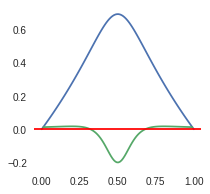

In [0]:
n = 2
eps = 1e-8
alpha = 5
M = 100

K = 0.0*np.random.rand(n, n)
K = (K * K.T) + 1 * np.eye(n)
K = torch.tensor(K)

p = np.array([(_, 1-_) for _ in np.linspace(0, 1, M)]).T
p = torch.tensor(p, requires_grad=True)
Kpa = (torch.clamp_min(K @ p, eps))**(alpha-1)
hp = torch.log(torch.clamp_min(torch.sum(p * Kpa, dim=0, keepdim=True), eps)) / (1-alpha)

Hs = []
for _ in np.linspace(0.01, 0.99, M):
    t = torch.tensor(_, requires_grad=True).double()
    ss = t * (t * K[0, 0] + (1 - t) * K[0, 1]) ** (alpha-1) + (1-t) * (t * K[1, 0] + (1 - t) * K[1, 1]) ** (alpha-1)
    H = hessian(torch.log(ss) / (1-alpha), t, create_graph=True).data.numpy()[0,0] / 100
    Hs.append(H)
    
plt.figure(figsize=(3,3))
plt.plot(np.linspace(0, 1, M), hp.data.numpy().T)
plt.plot(np.linspace(0.01, 0.99, M), Hs)
plt.axhline(0, c='r');

In [0]:
hp

tensor([[4.1017, 4.0580, 3.7830,  ..., 4.1078, 3.8852, 3.9542]],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [0]:
n, M = 5, 7
alpha = 1 + 5*np.random.rand()
eps = 1e-8

ones = np.array(n * [[1]])

K = 0.01*np.random.rand(n, n)
K = (K * K.T) + 1 * np.eye(n)

print(np.linalg.matrix_rank(K), np.linalg.det(K), np.min(np.linalg.eigvals(K)), np.max(np.linalg.eigvals(K)))

p = np.random.dirichlet(n*[1], M).T
q = np.random.dirichlet(n*[1], M).T



5 1.0002265333393499 0.9999257087094672 1.0001561969821466
3.7766416698652807 H^K_alpha is concave in p :  0.8571428571428571
(Kp)_i ** (alpha-1) is convex for alpha>=0 :  1.0


In [0]:
q = A @ p

In [0]:
eps = 1e-5

theta = 0.5#np.random.rand(M)
z = p * (1 - theta) + q * theta

Kpa = (eps + K @ p)**(alpha-1)
Kqa = (eps + K @ q)**(alpha-1)
Kza = (eps + K @ z)**(alpha-1)

hp = np.log(eps + np.sum(p * Kpa, axis=0, keepdims=True)) / (1-alpha)
hq = np.log(eps + np.sum(q * Kqa, axis=0, keepdims=True)) / (1-alpha)
hz = np.log(eps + np.sum(z * Kza, axis=0, keepdims=True)) / (1-alpha)

hpq = hp * (1 - theta) + hq * theta
Kpq = Kpa * (1 - theta) + Kqa * theta

print(alpha, 'H^K_alpha is concave in p : ', np.sum(hz + 1e-6 >= hpq) / M )

print('(Kp)_i ** (alpha-1) is convex for alpha>=0 : ', np.sum(Kpq + 1e-6 >= Kza) / (n *M))

3.7766416698652807 H^K_alpha is concave in p :  1.0
(Kp)_i ** (alpha-1) is convex for alpha>=0 :  1.0


In [0]:
Kpa[:, 3], Kqa[:, 3], Kza[:, 3]

(array([7.54700964e-02, 1.76584609e-04, 5.16975155e-03, 4.68556621e-06,
        7.80641746e-02]),
 array([2.60263525e-01, 2.23444862e-03, 9.29324720e-05, 2.64006362e-03,
        2.78121244e-03]),
 array([0.15007635, 0.00083146, 0.00135624, 0.00050473, 0.02364927]))

In [0]:
p[:, 3],  q[:, 3]

(array([0.39427411, 0.04449325, 0.15010635, 0.01200902, 0.39911727]),
 array([0.61578739, 0.11098193, 0.03529813, 0.11784783, 0.12008472]))

In [0]:
hz - hpq

array([[ 0.36461663,  0.08228499, -0.00135572,  0.06975953,  0.11788538,
         0.32750079,  0.10308002]])

In [0]:
ix = np.random.choice(M-1)
v = (K @ p[:, ix:ix+1]) ** (alpha - 1)
dp = p[:, ix:ix+1].T @ v
Q = (alpha / ((alpha - 1) * dp**2)) * ((alpha - 1) * dp * K * (v @ ones.T) - alpha * (v @ v.T))

np.linalg.eigvals(Q), np.min(np.linalg.eigvals(Q)) >= 0

(array([-2.12833732e+01,  2.92677135e-03,  1.84080101e-03,  1.65749610e-03,
         1.34967507e-03]), False)

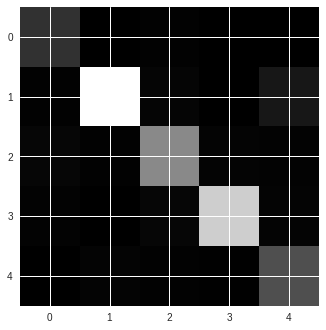

In [0]:
plt.imshow(Q)

In [0]:
(alpha / (alpha -1 )) * ((K @ p[:, 0:1]) @ ones.T)

array([[0.00013478, 0.00013478, 0.00013478, 0.00013478, 0.00013478],
       [0.00033431, 0.00033431, 0.00033431, 0.00033431, 0.00033431],
       [0.0002214 , 0.0002214 , 0.0002214 , 0.0002214 , 0.0002214 ],
       [0.00027861, 0.00027861, 0.00027861, 0.00027861, 0.00027861],
       [0.00016096, 0.00016096, 0.00016096, 0.00016096, 0.00016096]])

In [0]:
((K @ p[:, 0:1]) @ ones.T) @ p[:, 0:1]

array([[0.00013478],
       [0.00033431],
       [0.0002214 ],
       [0.00027861],
       [0.00016096]])

In [0]:
theta.shape 

(100,)

In [0]:
hp

array([[0.33665072, 0.40679459, 0.4369473 ]])

In [0]:
n = 10
ones = np.array(n * [[1]])

K = np.random.rand(n, n)
K = 0.5 * (K + K.T) + 0.5 * np.eye(n)

print(np.linalg.matrix_rank(K), np.linalg.det(K), np.min(np.linalg.eigvals(K)), np.max(np.linalg.eigvals(K)))

p = np.random.dirichlet(n*[1/n], 1).T
q = np.random.dirichlet(n*[1/n], 1).T

theta = np.random.rand()
z = (1 - theta) * p + theta * q
    
hp = -p.T @ np.log(K @ p)
hq = -q.T @ np.log(K @ q)
hz = -z.T @ np.log(K @ z)        

op = ones.T @ np.log(K @ p)
oq = ones.T @ np.log(K @ q)
oz = ones.T @ np.log(K @ z)

hmd = (1 - theta) * hp  + theta * hq
omd = (1 - theta) * op  + theta * oq

print(hp, hq, theta, hz, hmd, hz + 1e-6 >= hmd)
print(op, oq, theta, oz, omd, omd + 1e-6 >= omd)

10 -0.015047516687286521 -0.7559086530596489 5.6658395601067255
[[0.50159306]] [[0.65667144]] 0.9061831073279712 [[0.64220455]] [[0.64212247]] [[ True]]
[[-5.66118232]] [[-5.69672245]] 0.9061831073279712 [[-5.6911223]] [[-5.69338819]] [[ True]]


-0.5006342455898445

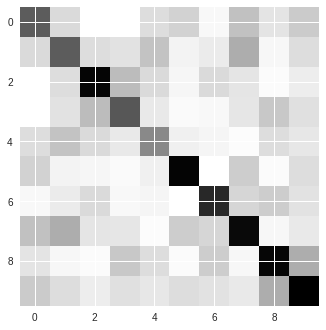

In [0]:
plt.imshow(K)

In [0]:
n = 100
ones = np.array(n * [[1]])

K = 10*np.random.rand(n, n)
K = 0.5 * (K + K.T)

A = np.random.rand(n, n)
for __ in range(25):
    A = A / A.sum(axis=0)
    A = (A.T / A.sum(axis=1)).T

p = np.random.dirichlet(n*[1/2], 1).T
q = A @ p

theta = np.random.dirichlet([1], 1)
z = (1 - theta) * p + theta * q
    
hz = z.T @ np.log(K @ z)
hmd = (1 - theta) * hp  + theta * hq
    
    
sq = -np.sort(-q, axis=0)
sp = -np.sort(-p, axis=0)

print('q < p: ', np.prod(sp.cumsum() + 1e-6 >= sq.cumsum()))

hp = p.T @ np.log(K @ p)
hq = q.T @ np.log(K @ q)

op = ones.T @ np.log(K @ p)
oq = ones.T @ np.log(K @ q)

print(hq, hp, hq <= hp + 1e-6)
print(oq, op, oq + 1e-6 >= op)

q < p:  1
[[1.60807072]] [[1.62210101]] [[ True]]
[[160.77528467]] [[161.03547798]] [[False]]


In [0]:
+ 1e-6 + sp.cumsum() >= sq.cumsum()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False])

In [0]:
sp.cumsum()[-1], sq.cumsum()[-1]

(0.9999999999999996, 1.0)

In [0]:
 ones.T @ np.log(K @ q), ones.T @ np.log(K @ p)

(array([[-71.15100339]]), array([[-70.27844668]]))

In [0]:
n = 100

ones = np.array(n * [[1]])

for _ in range(100):
    # Crea
    K = np.random.rand(n, n)
    K = 0.5 * (K + K.T)

    # Initialize A randomly and iterate normalization
    A = np.random.rand(n, n)
    for __ in range(20):
        A = A / A.sum(axis=0)
        A = (A.T / A.sum(axis=1)).T

    #W = A.T @ K @ A
    W = K @ A
    
    p = np.random.dirichlet(n*[1/2], 1).T
    hp = p.T @ np.log(K @ p)
    
    q = A @ p
    #q = np.random.dirichlet(n*[1/2], 1).T
    hq = q.T @ np.log(K @ q)
    
    theta = np.random.dirichlet([1], 1)
    z = (1 - theta) * p + theta * q
    
    hz = z.T @ np.log(K @ z)
    hmd = (1 - theta) * hp  + theta * hq
    
    if not hz + 1e-6 >= hmd:
        print('BBBBB')
        print(hz, hmd)
    
    if not (p.T @ np.log(K @ p) >= q.T @ np.log(K @ q) )[0][0]:
        print('CCCC')
        
#     if not (p.T @ np.log(K @ p) >= p.T @ np.log(W @ p) )[0][0]:
#         print (_, 'AAAAAAAAAA', p.T)
#         print(A)
#         print(A.sum(axis=0),  A.sum(axis=1))
#         print(K)
#         print((p.T @ np.log(K @ p) - p.T @ np.log(W @ p) ))
#         break

CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC


In [0]:
(p.T @ np.log(K @ p) > p.T @ np.log(W @ p) )[0][0]

False

True

In [0]:
(W - K) @ p 

array([[-0.06728522],
       [ 0.03319462],
       [ 0.1253303 ],
       [-0.01483111],
       [-0.08110535]])

In [0]:
W.sum()

12.836204992809511

In [0]:
class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.LeakyReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out
    
class LinearClassifier(nn.Module):
    def __init__(self, input_size):
        super(LinearClassifier, self).__init__()
        self.model = nn.Linear(input_size, 1)
        
    def forward(self, x):
        return self.model(x)



## Mixture of Gaussians

In [0]:
from scipy.stats import multivariate_normal

def sample_mix(rvs, p, n_samples, as_torch=True):
    out = []
    out_class = []
    for i in range(n_samples):
        j = np.random.choice(len(p), p=p)
        out += [np.random.multivariate_normal(rvs[j].mean, rvs[j].cov)]
        out_class += [[j%2]]
    
    if as_torch:
        return torch.Tensor(np.stack(out)), torch.Tensor(np.stack(out_class))
    else:
        return np.stack(out), np.stack(out_class)

def eval_mix_pdf(x, rvs, p):
    cont = np.zeros_like(x[:, :, 0])
    for _ in range(len(mus)):
        cont += p[_] * rvs[_].pdf(x)
    return cont

In [0]:
mus = [ [-1, 2],
        [1, -2]]

covs = [ [[1, 0], [0, 1]], 
         [[1, 0], [0, 1]] ]

p = [1, 1]
p = np.array(p) / np.sum(p)

rvs = []
for _ in range(len(mus)):
    rvs.append(multivariate_normal(np.array(mus[_]), 0.1*np.array(covs[_])))
    
x, y = np.mgrid[-5:4:.05, -4:5:.05]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

z_dim, batch_size = 10, 32

generator = GeneratorFC(z_dim, d+1, gen_hiddens)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.9, 0.99))

classifier = LinearClassifier(d)
c_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3, betas=(0.9, 0.99))

bce_loss = torch.nn.BCEWithLogitsLoss()

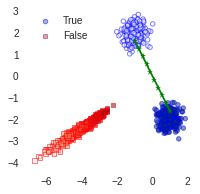

In [0]:
x_real, y_real = sample_mix(rvs, p, n_samples=500, as_torch=False)    
z = torch.randn(500, z_dim)
x_fake = generator(z).data.numpy()
x_fake, y_fake = x_fake[:, :-1], x_fake[:, -1:] 
    

plt.figure(figsize=(3, 3))
plt.scatter(x_real[:, 0], x_real[:, 1], s=20, c=y_real[:, 0], label='True', cmap='Blues', linewidths=1, edgecolors='b', alpha=0.5)
plt.scatter(x_fake[:, 0], x_fake[:, 1], s=20, c=y_fake[:, 0], marker='s', label='False', cmap='Reds', linewidths=1, edgecolors='r', alpha=0.5)

w1, w2 = list(classifier.model.parameters())[0].data.numpy()[0]
b = list(classifier.model.parameters())[1].data.numpy()[0]
x = np.linspace(-1, 1, 10)
y = (-w1*x - b)/w2
plt.plot(x, y, '-*', c='g')

plt.legend(loc='best');

In [0]:
for _ in range(1000):
    
    g_optimizer.zero_grad()
    
    x_real, y_real = sample_mix(rvs, p, n_samples=batch_size, as_torch=True)             
    z = torch.randn(batch_size, z_dim)
    x_fake = generator(z)
    x_fake, y_fake = x_fake[:, :-1], torch.sigmoid(x_fake[:, -1:]) 
    
    for c_iter in range(50):
        c_optimizer.zero_grad()
        loss = bce_loss(classifier(x_fake), y_fake)
        #loss = bce_loss(classifier(x_real), y_real)
        
        if (_ == 0 or (_> 0 and _ % 100 == 0)) and c_iter % 25 == 0:
            print("C %d - %.4f" % (c_iter, loss.item()))
        
        loss.backward(retain_graph=True) 
        c_optimizer.step()
    
    loss = bce_loss(classifier(x_real), y_real)
    loss.backward() 
    g_optimizer.step()
    
    if _ == 0 or (_> 0 and _ % 100 == 0):
        print("%d - %.4f" % (_, loss.item()))

C 0 - 0.7129
C 25 - 0.7105
0 - 0.4103
C 0 - 0.0016
C 25 - 0.0016
100 - 1.3933
C 0 - 0.0008
C 25 - 0.0008
200 - 1.2716
C 0 - 0.0002
C 25 - 0.0002
300 - 1.1231


KeyboardInterrupt: ignored

array([[-1.0452721, -1.43722  ]], dtype=float32)

In [0]:
x_real, y_real = sample_mix(rvs, p, n_samples=batch_size, as_torch=True)             
    
torch.sum(torch.sign(classifier(x_real)) == (2*y_real - 1))

tensor(32)

In [0]:
z = torch.randn(500, z_dim)
x_fake = generator(z)
x_fake, y_fake = x_fake[:, :-1], x_fake[:, -1:] 
torch.sign(classifier(x_fake)) == y_fake

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],